In [2]:
import pandas as pd

df = pd.read_csv("../data/billdata.csv")
df.head()


,year,month,grid_kwh,bill_amount,solar_kwh
0,2016,12,284,663,0.0
1,2017,1,270,640,0.0
2,2017,2,242,678,0.0
3,2017,3,242,678,0.0
4,2017,4,242,678,0.0


In [3]:
df.columns


Index(['year', 'month', 'grid_kwh', 'bill_amount', 'solar_kwh'], dtype='object')

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         105 non-null    int64  
 1   month        105 non-null    int64  
 2   grid_kwh     105 non-null    int64  
 3   bill_amount  105 non-null    int64  
 4   solar_kwh    105 non-null    float64
dtypes: float64(1), int64(4)
memory usage: 4.2 KB


In [5]:
df.describe()


,year,month,grid_kwh,bill_amount,solar_kwh
count,105.000000,105.000000,105.000000,105.000000,105.000000
mean,2020.952381,6.533333,233.819048,631.019048,57.884762
std,2.650765,3.502929,121.891170,483.173742,93.522581
min,2016.000000,1.000000,0.000000,-1291.000000,0.000000
25%,2019.000000,3.000000,169.000000,430.000000,0.000000
50%,2021.000000,7.000000,238.000000,619.000000,0.000000
75%,2023.000000,10.000000,284.000000,815.000000,156.900000
max,2025.000000,12.000000,622.000000,2469.000000,267.400000


In [6]:
import pandas as pd

# Create a proper date column
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
)

# Flag solar installation
df["solar_installed"] = (df["solar_kwh"] > 0).astype(int)

# Net dependency on grid
df["net_grid_dependency"] = df["grid_kwh"] - df["solar_kwh"]

df.head()


,year,month,grid_kwh,bill_amount,solar_kwh,date,solar_installed,net_grid_dependency
0,2016,12,284,663,0.0,2016-12-01,0,284.0
1,2017,1,270,640,0.0,2017-01-01,0,270.0
2,2017,2,242,678,0.0,2017-02-01,0,242.0
3,2017,3,242,678,0.0,2017-03-01,0,242.0
4,2017,4,242,678,0.0,2017-04-01,0,242.0


In [7]:
solar_df = df[df["solar_kwh"] > 0]

solar_df.groupby("month")["solar_kwh"].mean()


month
1     217.450000
2     220.900000
3     253.950000
4     262.300000
5     244.500000
6     141.900000
7     129.150000
8     184.933333
9     190.733333
10    199.433333
11    203.900000
12    200.200000
Name: solar_kwh, dtype: float64

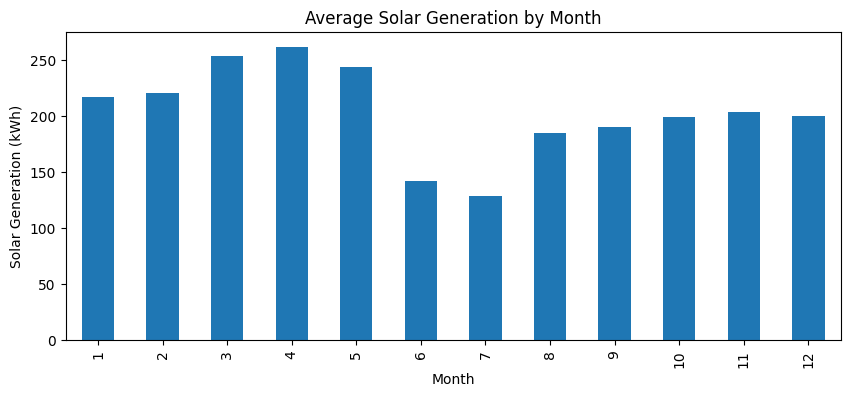

In [8]:
import matplotlib.pyplot as plt

monthly_solar = solar_df.groupby("month")["solar_kwh"].mean()

plt.figure(figsize=(10,4))
monthly_solar.plot(kind="bar")
plt.title("Average Solar Generation by Month")
plt.xlabel("Month")
plt.ylabel("Solar Generation (kWh)")
plt.show()


In [9]:
annual_solar = solar_df.groupby("year")["solar_kwh"].sum()
annual_solar


year
2023    1322.7
2024    2466.4
2025    2288.8
Name: solar_kwh, dtype: float64

In [10]:
GRID_TARIFF = 6.5      # ₹/kWh (household grid tariff)
SOLAR_LCOE = 4.0       # ₹/kWh (estimated rooftop LCOE)
INSTALL_COST = 1_70_000



In [11]:
annual_savings = annual_solar * GRID_TARIFF
cumulative_savings = annual_savings.cumsum()


In [12]:
solar_df = df[df["solar_kwh"] > 0].copy()

solar_df = solar_df.sort_values("date")

solar_df[["date", "solar_kwh"]].head()


,date,solar_kwh
74,2023-06-01,49.2
75,2023-07-01,122.2
76,2023-07-01,122.2
77,2023-08-01,231.6
78,2023-09-01,190.5


In [13]:
solar_df["month_num"] = solar_df["month"]
solar_df["time_index"] = range(len(solar_df))

solar_df.head()


,year,month,grid_kwh,bill_amount,solar_kwh,date,solar_installed,net_grid_dependency,month_num,time_index
74,2023,6,340,1293,49.2,2023-06-01,1,290.8,6,0
75,2023,7,559,2265,122.2,2023-07-01,1,436.8,7,1
76,2023,7,57,2469,122.2,2023-07-01,1,-65.2,7,2
77,2023,8,197,698,231.6,2023-08-01,1,-34.6,8,3
78,2023,9,50,271,190.5,2023-09-01,1,-140.5,9,4


In [14]:
from sklearn.linear_model import LinearRegression

X = solar_df[["month_num", "time_index"]]
y = solar_df["solar_kwh"]

model = LinearRegression()
model.fit(X, y)

model.coef_, model.intercept_


(array([-4.1377568 ,  1.43992719]), np.float64(203.0262520019812))

In [15]:
import numpy as np

future_months = 25 * 12  # 25 years

last_time_index = solar_df["time_index"].iloc[-1]

future_data = []

current_year = solar_df["year"].iloc[-1]
current_month = solar_df["month"].iloc[-1]

for i in range(1, future_months + 1):
    month = (current_month + i - 1) % 12 + 1
    year = current_year + (current_month + i - 1) // 12
    future_data.append({
        "year": year,
        "month": month,
        "month_num": month,
        "time_index": last_time_index + i
    })

future_df = pd.DataFrame(future_data)


In [16]:
future_df["predicted_solar_kwh"] = model.predict(
    future_df[["month_num", "time_index"]]
)

future_df.head()


,year,month,month_num,time_index,predicted_solar_kwh
0,2025,12,12,31,198.010913
1,2026,1,1,32,244.966165
2,2026,2,2,33,242.268336
3,2026,3,3,34,239.570506
4,2026,4,4,35,236.872676


In [17]:
future_df["predicted_savings"] = future_df["predicted_solar_kwh"] * GRID_TARIFF


In [18]:
historical_savings = annual_solar * GRID_TARIFF

last_historical_year = historical_savings.index.max()

future_annual = (
    future_df
    .groupby("year")["predicted_savings"]
    .sum()
    .loc[lambda x: x.index > last_historical_year]
)


combined_savings = pd.concat([historical_savings, future_annual])
cumulative_savings = combined_savings.cumsum()
cumulative_savings



year
2023      8597.550000
2024     24629.150000
2025     39506.350000
2026     57456.341991
2027     76754.105832
2028     97399.641524
2029    119392.949067
2030    142734.028461
2031    167422.879705
2032    193459.502801
2033    220843.897747
2034    249576.064544
2035    279656.003191
2036    311083.713690
2037    343859.196039
2038    377982.450239
2039    413453.476290
2040    450272.274191
2041    488438.843943
2042    527953.185547
2043    568815.299000
2044    611025.184305
2045    654582.841460
2046    699488.270467
2047    745741.471324
2048    793342.444031
2049    842291.188590
2050    888492.776040
dtype: float64

In [19]:
break_even_year = cumulative_savings[cumulative_savings >= INSTALL_COST]
break_even_year


year
2032    193459.502801
2033    220843.897747
2034    249576.064544
2035    279656.003191
2036    311083.713690
2037    343859.196039
2038    377982.450239
2039    413453.476290
2040    450272.274191
2041    488438.843943
2042    527953.185547
2043    568815.299000
2044    611025.184305
2045    654582.841460
2046    699488.270467
2047    745741.471324
2048    793342.444031
2049    842291.188590
2050    888492.776040
dtype: float64

In [21]:
annual_savings = annual_solar * GRID_TARIFF
annual_savings



year
2023     8597.55
2024    16031.60
2025    14877.20
Name: solar_kwh, dtype: float64

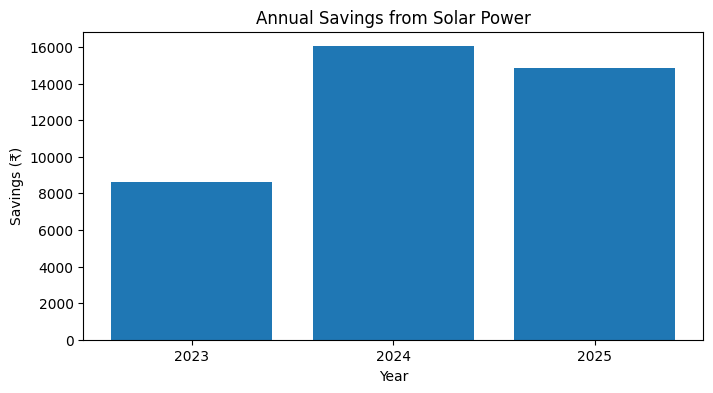

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(annual_savings.index.astype(str), annual_savings.values)
plt.xlabel("Year")
plt.ylabel("Savings (₹)")
plt.title("Annual Savings from Solar Power")
plt.show()


In [23]:
cumulative_savings = annual_savings.cumsum()
cumulative_savings


year
2023     8597.55
2024    24629.15
2025    39506.35
Name: solar_kwh, dtype: float64

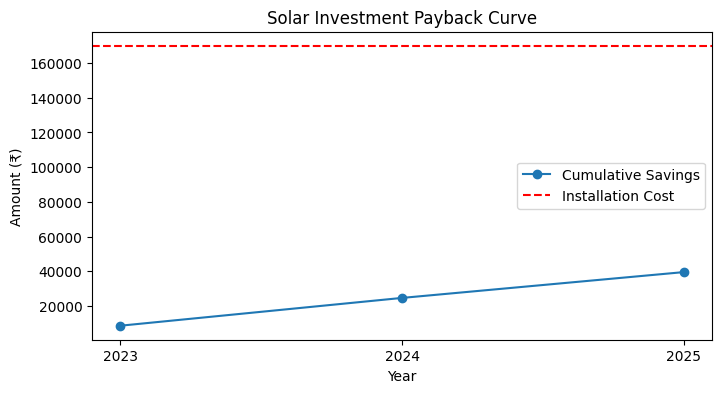

In [24]:
plt.figure(figsize=(8,4))
plt.plot(
    cumulative_savings.index.astype(str),
    cumulative_savings.values,
    marker="o",
    label="Cumulative Savings"
)

plt.axhline(
    INSTALL_COST,
    color="red",
    linestyle="--",
    label="Installation Cost"
)

plt.xlabel("Year")
plt.ylabel("Amount (₹)")
plt.title("Solar Investment Payback Curve")
plt.legend()
plt.show()


In [25]:
summary_df = pd.DataFrame({
    "Annual Savings (₹)": annual_savings.round(0),
    "Cumulative Savings (₹)": cumulative_savings.round(0)
})

summary_df


,Annual Savings (₹),Cumulative Savings (₹)
year,,
2023,8598.0,8598.0
2024,16032.0,24629.0
2025,14877.0,39506.0
